# LSTM 生成音乐 - 分析
## 引入

In [ ]:
import os
import time
import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from music21 import instrument, note, stream, chord, duration
from models import create_network, sample_with_temp

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 环境 & 模型参数

In [2]:
# run params
section = 'compose'
run_id = '0001'
music_name = 'cello'
run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## 加载模型参数

In [3]:
store_folder = os.path.join(run_folder, 'store')

with open(os.path.join(store_folder, 'distincts'), 'rb') as filepath:
    distincts = pkl.load(filepath)
    note_names, n_notes, duration_names, n_durations = distincts

with open(os.path.join(store_folder, 'lookups'), 'rb') as filepath:
    lookups = pkl.load(filepath)
    note_to_int, int_to_note, duration_to_int, int_to_duration = lookups

In [4]:
weights_folder = os.path.join(run_folder, 'weights')
weights_file = 'weights.h5'

model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)

# Load the weights to each node
weight_source = os.path.join(weights_folder,weights_file)
model.load_weights(weight_source)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    47000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1700        input_2[0][0]                    
______________________________________________________________________________________________

## 生成乐曲

In [5]:
# prediction params
notes_temp=0.5
duration_temp = 0.5
max_extra_notes = 50
max_seq_len = 32
seq_len = 32

# notes = ['START', 'D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3','D3', 'D3', 'E3', 'D3', 'G3', 'F#3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]

# notes = ['START', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3','F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3', 'F#3', 'G#3', 'F#3', 'E3']
# durations = [0, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2, 0.75, 0.25, 1, 1, 1, 2]

notes = ['START']
durations = [0]

if seq_len is not None:
    notes = ['START'] * (seq_len - len(notes)) + notes
    durations = [0] * (seq_len - len(durations)) + durations

sequence_length = len(notes)

In [6]:
prediction_output = []
notes_input_sequence = []
durations_input_sequence = []

overall_preds = []

for n, d in zip(notes, durations):
    note_int = note_to_int[n]
    duration_int = duration_to_int[d]

    notes_input_sequence.append(note_int)
    durations_input_sequence.append(duration_int)

    prediction_output.append([n, d])

    if n != 'START':
        midi_note = note.Note(n)

        new_note = np.zeros(128)
        new_note[midi_note.pitch.midi] = 1
        overall_preds.append(new_note)

att_matrix = np.zeros(shape=(max_extra_notes+sequence_length, max_extra_notes))

for note_index in range(max_extra_notes):
    prediction_input = [
        np.array([notes_input_sequence]), np.array([durations_input_sequence])
    ]

    notes_prediction, durations_prediction = model.predict(
        prediction_input, verbose=0)
    if use_attention:
        att_prediction = att_model.predict(prediction_input, verbose=0)[0]
        att_matrix[
            (note_index-len(att_prediction)+sequence_length):(note_index+sequence_length),
            note_index
        ] = att_prediction

    new_note = np.zeros(128)

    for idx, n_i in enumerate(notes_prediction[0]):
        try:
            note_name = int_to_note[idx]
            midi_note = note.Note(note_name)
            new_note[midi_note.pitch.midi] = n_i
        except:
            pass
    overall_preds.append(new_note)

    i1 = sample_with_temp(notes_prediction[0], notes_temp)
    i2 = sample_with_temp(durations_prediction[0], duration_temp)

    note_result = int_to_note[i1]
    duration_result = int_to_duration[i2]

    prediction_output.append([note_result, duration_result])

    notes_input_sequence.append(i1)
    durations_input_sequence.append(i2)

    if len(notes_input_sequence) > max_seq_len:
        notes_input_sequence = notes_input_sequence[1:]
        durations_input_sequence = durations_input_sequence[1:]

    if note_result == 'START':
        break

overall_preds = np.transpose(np.array(overall_preds))
print('Generated sequence of {} notes'.format(len(prediction_output)))


c:\Users\86153\Anaconda3\envs\TensorFlow\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Generated sequence of 82 notes


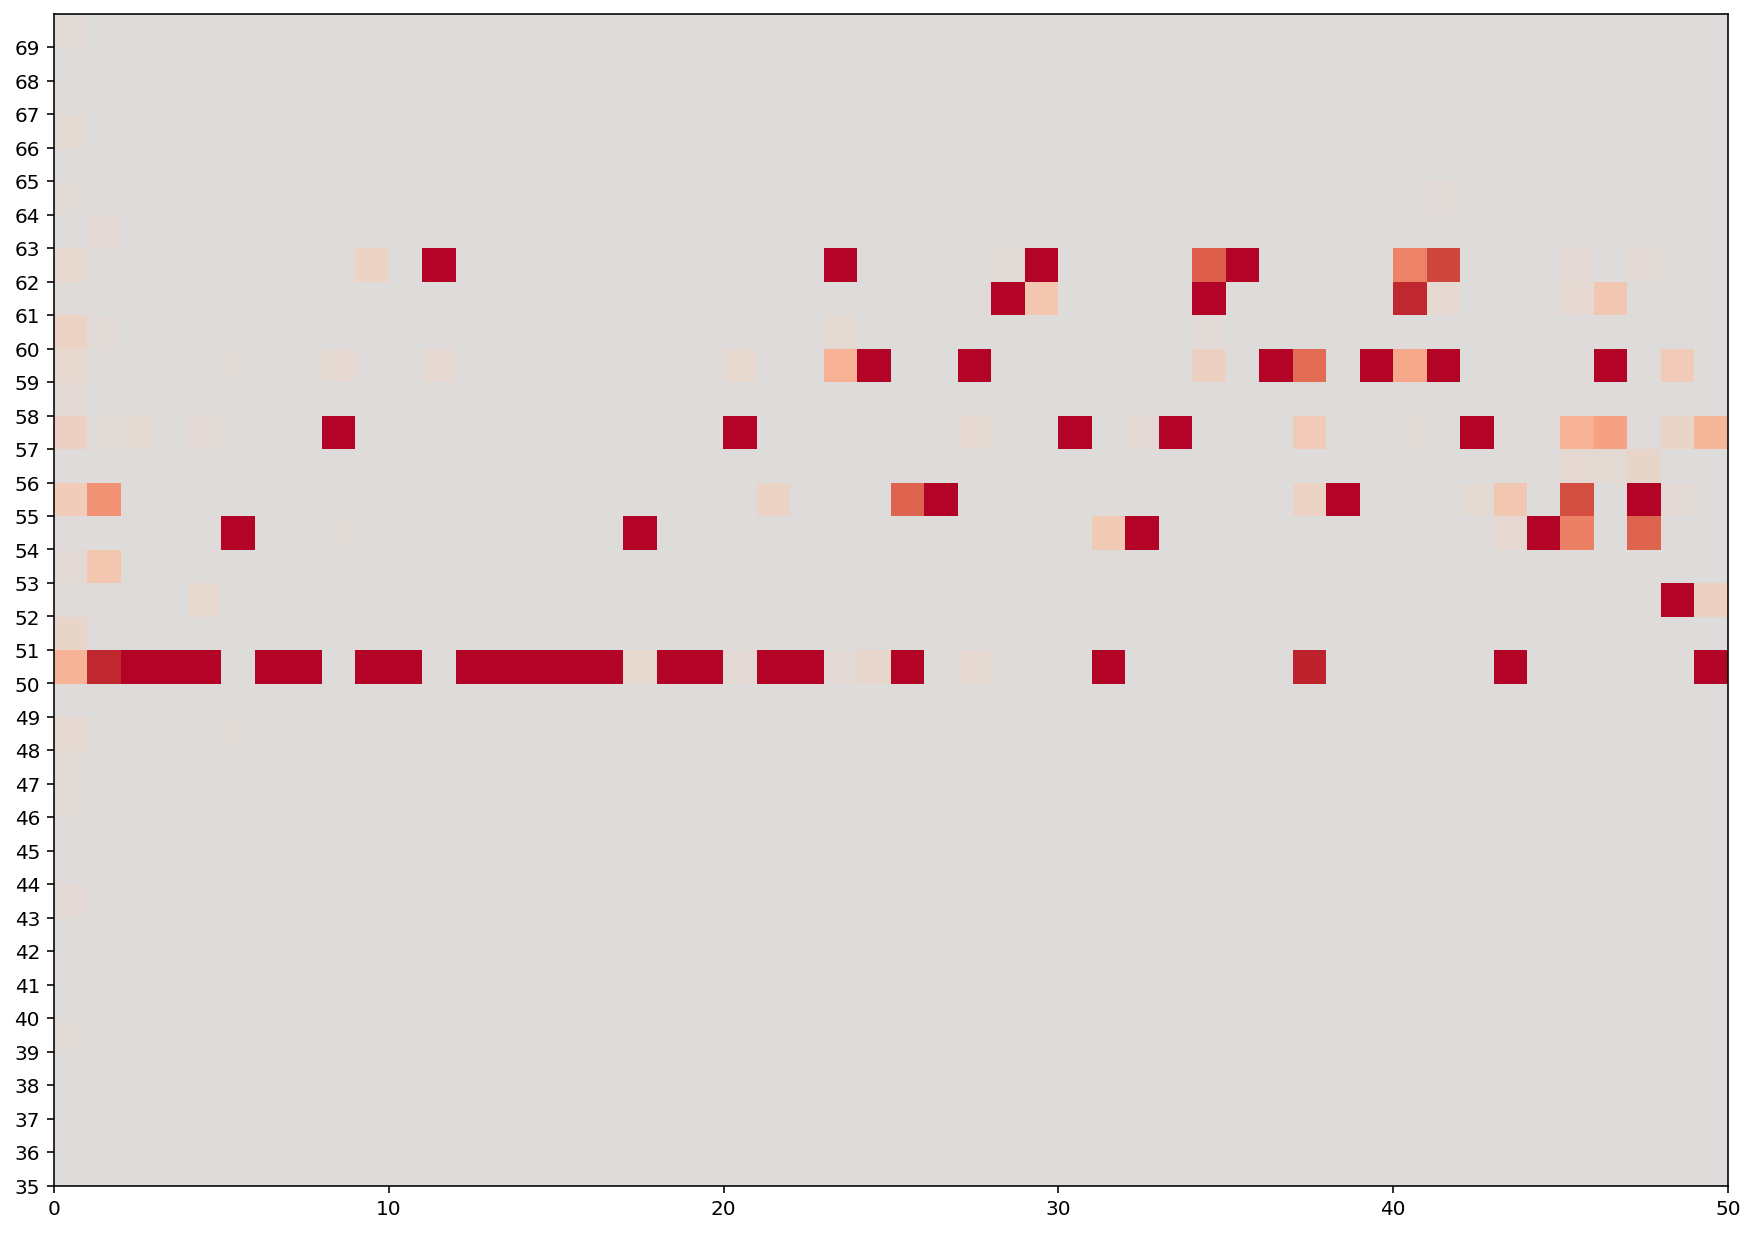

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_yticks([int(j) for j in range(35, 70)])

plt.imshow(overall_preds[35:70, :], origin="lower", cmap='coolwarm',
           vmin=-0.5, vmax=0.5, extent=[0, max_extra_notes, 35, 70])


In [8]:
output_folder = os.path.join(run_folder, 'output')

midi_stream = stream.Stream()

# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # pattern is a chord
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(current_note)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
    elif note_pattern == 'rest':
        # pattern is a rest
        new_note = note.Rest()
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
    elif note_pattern != 'START':
        # pattern is a note
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)


midi_stream = midi_stream.chordify()
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write('midi', fp=os.path.join(
    output_folder, 'output-' + timestr + '.mid'))

'run/compose/0001_cello\\output\\output-20221004-001413.mid'

[Text(0, 0, 'D3'),
 Text(1, 0, 'D3'),
 Text(2, 0, 'D3'),
 Text(3, 0, 'D3'),
 Text(4, 0, 'D3'),
 Text(5, 0, 'F#3'),
 Text(6, 0, 'D3'),
 Text(7, 0, 'D3'),
 Text(8, 0, 'A3'),
 Text(9, 0, 'D3'),
 Text(10, 0, 'D3'),
 Text(11, 0, 'D4'),
 Text(12, 0, 'D3'),
 Text(13, 0, 'D3'),
 Text(14, 0, 'D3'),
 Text(15, 0, 'D3'),
 Text(16, 0, 'D3'),
 Text(17, 0, 'F#3'),
 Text(18, 0, 'D3'),
 Text(19, 0, 'D3'),
 Text(20, 0, 'A3'),
 Text(21, 0, 'D3'),
 Text(22, 0, 'D3'),
 Text(23, 0, 'D4'),
 Text(24, 0, 'B3'),
 Text(25, 0, 'D3'),
 Text(26, 0, 'G3'),
 Text(27, 0, 'B3'),
 Text(28, 0, 'C#4'),
 Text(29, 0, 'D4'),
 Text(30, 0, 'A3'),
 Text(31, 0, 'D3'),
 Text(32, 0, 'F#3'),
 Text(33, 0, 'A3'),
 Text(34, 0, 'C#4'),
 Text(35, 0, 'D4'),
 Text(36, 0, 'B3'),
 Text(37, 0, 'D3'),
 Text(38, 0, 'G3'),
 Text(39, 0, 'B3'),
 Text(40, 0, 'D4'),
 Text(41, 0, 'B3'),
 Text(42, 0, 'A3'),
 Text(43, 0, 'D3'),
 Text(44, 0, 'F#3'),
 Text(45, 0, 'G3'),
 Text(46, 0, 'B3'),
 Text(47, 0, 'G3'),
 Text(48, 0, 'E3'),
 Text(49, 0, 'D3')]

[Text(0, 0, 'START'),
 Text(0, 1, 'START'),
 Text(0, 2, 'D3'),
 Text(0, 3, 'D3'),
 Text(0, 4, 'D3'),
 Text(0, 5, 'D3'),
 Text(0, 6, 'D3'),
 Text(0, 7, 'F#3'),
 Text(0, 8, 'D3'),
 Text(0, 9, 'D3'),
 Text(0, 10, 'A3'),
 Text(0, 11, 'D3'),
 Text(0, 12, 'D3'),
 Text(0, 13, 'D4'),
 Text(0, 14, 'D3'),
 Text(0, 15, 'D3'),
 Text(0, 16, 'D3'),
 Text(0, 17, 'D3'),
 Text(0, 18, 'D3'),
 Text(0, 19, 'F#3'),
 Text(0, 20, 'D3'),
 Text(0, 21, 'D3'),
 Text(0, 22, 'A3'),
 Text(0, 23, 'D3'),
 Text(0, 24, 'D3'),
 Text(0, 25, 'D4'),
 Text(0, 26, 'B3'),
 Text(0, 27, 'D3'),
 Text(0, 28, 'G3'),
 Text(0, 29, 'B3'),
 Text(0, 30, 'C#4'),
 Text(0, 31, 'D4'),
 Text(0, 32, 'A3'),
 Text(0, 33, 'D3'),
 Text(0, 34, 'F#3'),
 Text(0, 35, 'A3'),
 Text(0, 36, 'C#4'),
 Text(0, 37, 'D4'),
 Text(0, 38, 'B3'),
 Text(0, 39, 'D3'),
 Text(0, 40, 'G3'),
 Text(0, 41, 'B3'),
 Text(0, 42, 'D4'),
 Text(0, 43, 'B3'),
 Text(0, 44, 'A3'),
 Text(0, 45, 'D3'),
 Text(0, 46, 'F#3'),
 Text(0, 47, 'G3'),
 Text(0, 48, 'B3'),
 Text(0, 49, 'G3')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

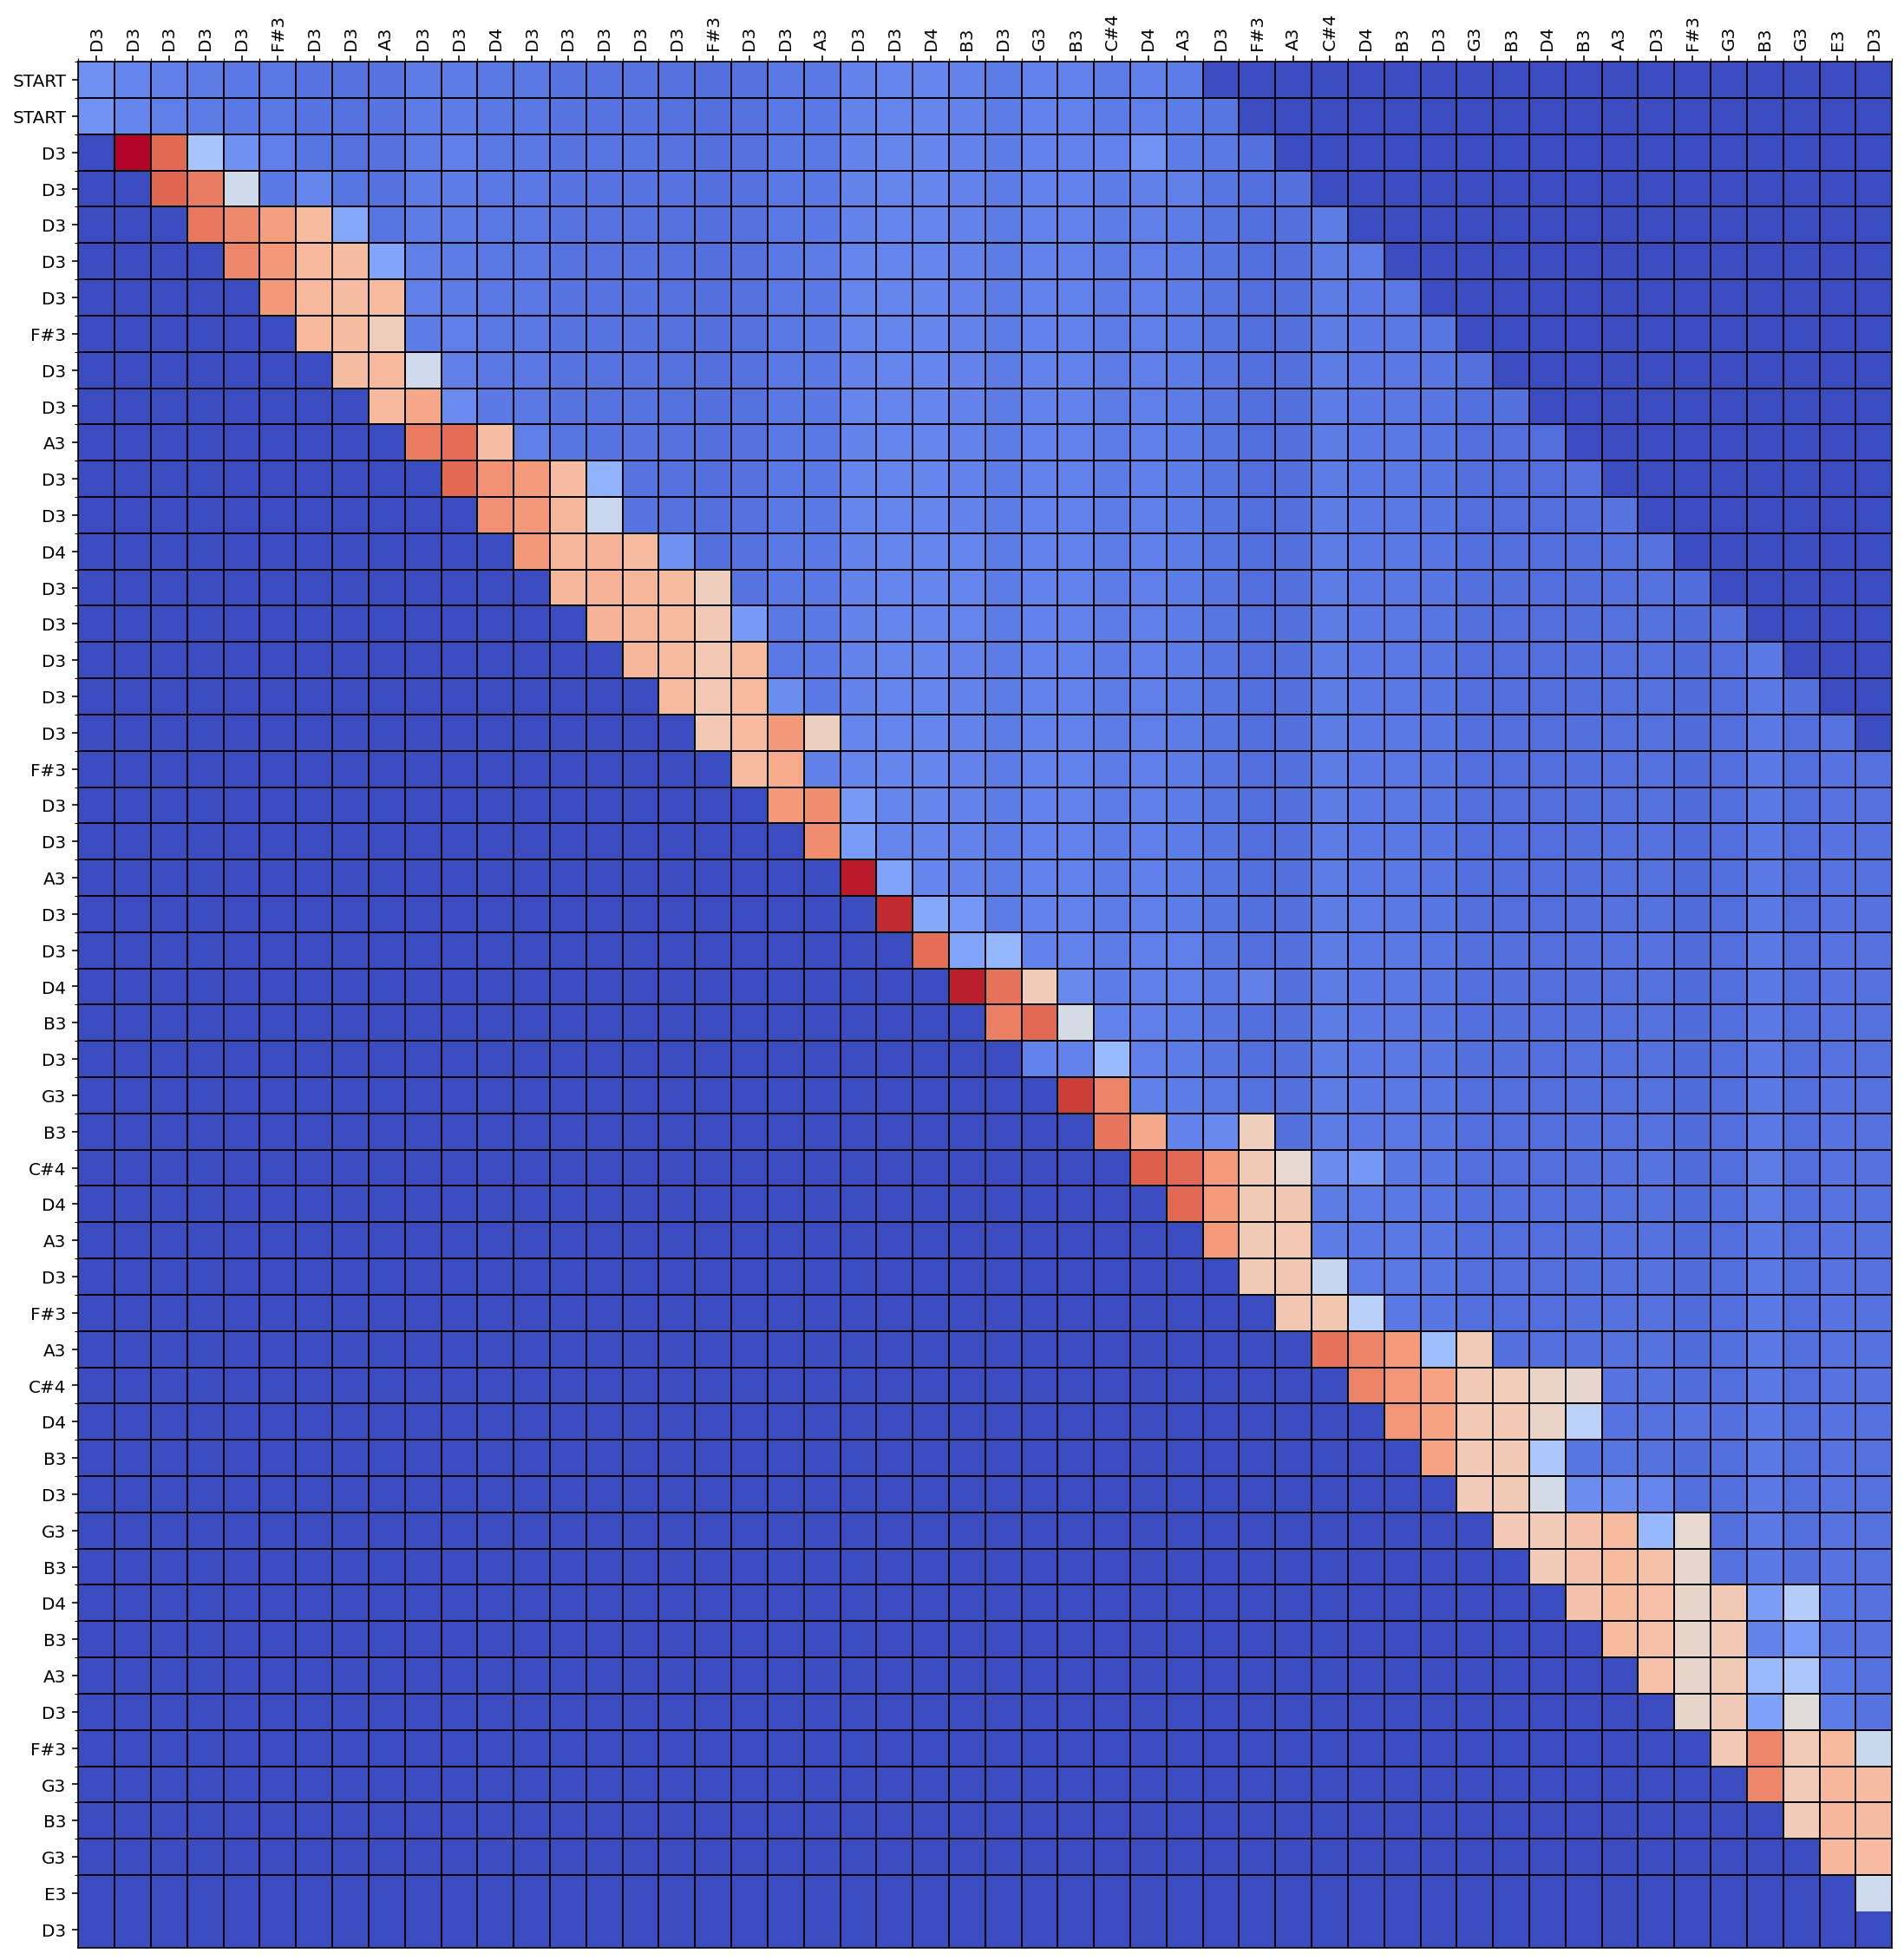

In [9]:
# attention plot
if use_attention:
    fig, ax = plt.subplots(figsize=(20, 20))

    im = ax.imshow(att_matrix[(seq_len-2):, ],
                   cmap='coolwarm', interpolation='nearest')

    # Minor ticks
    ax.set_xticks(
        np.arange(-.5, len(prediction_output) - seq_len, 1), minor=True)
    ax.set_yticks(
        np.arange(-.5, len(prediction_output) - seq_len, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(prediction_output) - seq_len))
    ax.set_yticks(np.arange(len(prediction_output) - seq_len+2))
    # ... and label them with the respective list entries
    ax.set_xticklabels([n[0] for n in prediction_output[(seq_len):]])
    ax.set_yticklabels([n[0] for n in prediction_output[(seq_len - 2):]])

    # ax.grid(color='black', linestyle='-', linewidth=1)

    ax.xaxis.tick_top()

    plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va="center",
             rotation_mode="anchor")

    plt.show()
